# Master's thesis code

**Sofia Morais - 152021001**

In [165]:
# Load the packages
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import shap
import numpy as np
import pickle
import tensorflow as tf
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold
from scalecast.Forecaster import Forecaster
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## 1. DATA PREPARATION

### 1.1 Creating the new dataset

In [2]:
# Import the original dataset and save it as "original"
original = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/original/original.xlsx', header=1,index_col=0)

# Data transformation
original.index.name='Timestamp'
original = original.rename(columns={'google': 'Popularity'})
original = original.rename(columns={'n-transactions-per-block': 'Total-circulating-BTC'}) # correct the name of one variable
original = original.rename(columns={'n-transactions-per-block.1': 'n-transactions-per-block'}) # correct the name of one variable
original.drop(original.columns[-21:], axis=1, inplace=True) # Delete the columns that you will not use
original.head() # Check the first observations

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,n-transactions-total,Popularity,Open,n-payments-per-block,Total-circulating-BTC,cost-per-transaction-percent,fees-usd-per-transaction,n-unique-addresses,n-transactions-per-block,output-volume
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,183961799.0,43,963.4,0.0,1808.982832,0.757827,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,183961799.0,74,995.4,0.0,1808.982832,0.726644,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,183961799.0,69,1017.0,0.0,1808.982832,0.718670,0.288061,468609.6,272924.100000,1.693024e+06
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,183961799.0,79,1033.3,0.0,1830.788898,0.668387,0.307901,488315.4,276578.033333,1.797751e+06
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,184884526.0,100,1135.4,0.0,1830.788898,0.705463,0.307901,488315.4,276578.033333,1.797751e+06


In [3]:
# Import the confidence index dataset and save it
confidence = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/consumer confidence index.csv',index_col='TIME')

# Data transformation
confidence= confidence[confidence["LOCATION"].str.contains("OECD")==True]
confidence= confidence[confidence["LOCATION"].str.contains("OECDE")==False]
confidence= confidence.drop(['LOCATION','INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'], axis='columns')

# Delete the the rows that you will not use
for i in confidence.index:
    if i>'2021-06':
        confidence=confidence.drop(i)
    continue

# Check the last values to make sure that you the previous code worked
confidence.head()

,Value
TIME,
2017-01,100.5115
2017-02,100.5401
2017-03,100.6480
2017-04,100.7638
2017-05,100.8411


In [4]:
# Create an empty column
original['Confidence']=''

# Add the confidence index variable to the original dataset
for i in original.index.strftime('%Y-%m'):
    for j in confidence.index:
        if i==j:
            original['Confidence'][i]=confidence['Value'][j]
    continue
original['Confidence'].head(32) #check the values between the first 2 months to guarantee that the values were  copied

Timestamp
2017-01-01    100.5115
2017-01-02    100.5115
2017-01-03    100.5115
2017-01-04    100.5115
2017-01-05    100.5115
2017-01-06    100.5115
2017-01-07    100.5115
2017-01-08    100.5115
2017-01-09    100.5115
2017-01-10    100.5115
2017-01-11    100.5115
2017-01-12    100.5115
2017-01-13    100.5115
2017-01-14    100.5115
2017-01-15    100.5115
2017-01-16    100.5115
2017-01-17    100.5115
2017-01-18    100.5115
2017-01-19    100.5115
2017-01-20    100.5115
2017-01-21    100.5115
2017-01-22    100.5115
2017-01-23    100.5115
2017-01-24    100.5115
2017-01-25    100.5115
2017-01-26    100.5115
2017-01-27    100.5115
2017-01-28    100.5115
2017-01-29    100.5115
2017-01-30    100.5115
2017-01-31    100.5115
2017-02-01    100.5401
Name: Confidence, dtype: object

In [5]:
# Import the variable gold save it
gold = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/gold.xlsx', header=4,index_col=1,sheet_name='Data')

# Create date and time with dataframe
data = pd.date_range('2014-01', periods = 104, freq ='M')

#Add to gold dataframe
gold.index=data

# Transform the data
gold.index=gold.index.strftime('%Y-%m')
gold.index.name='Timestamp'
gold= gold.drop(gold.columns[0], axis=1)
gold= gold.rename(columns={'Unnamed: 2': 'Price'})

# Delete the the rows that you will not use
for i in gold.index:
    if i<'2017-01' or i>'2021-06':
        gold=gold.drop(i)
    continue

gold.head()

,Price
Timestamp,
2017-01,1192.10
2017-02,1234.20
2017-03,1231.42
2017-04,1266.88
2017-05,1246.04


In [6]:
# Create an empty column
original['Gold']=''

# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in gold.index:
        if i==j:
            original['Gold'][i]=gold['Price'][j]
            
        continue
original['Gold'].head(32) #check the values between the first 2 months to guarantee that the values were copied

Timestamp
2017-01-01    1192.1
2017-01-02    1192.1
2017-01-03    1192.1
2017-01-04    1192.1
2017-01-05    1192.1
2017-01-06    1192.1
2017-01-07    1192.1
2017-01-08    1192.1
2017-01-09    1192.1
2017-01-10    1192.1
2017-01-11    1192.1
2017-01-12    1192.1
2017-01-13    1192.1
2017-01-14    1192.1
2017-01-15    1192.1
2017-01-16    1192.1
2017-01-17    1192.1
2017-01-18    1192.1
2017-01-19    1192.1
2017-01-20    1192.1
2017-01-21    1192.1
2017-01-22    1192.1
2017-01-23    1192.1
2017-01-24    1192.1
2017-01-25    1192.1
2017-01-26    1192.1
2017-01-27    1192.1
2017-01-28    1192.1
2017-01-29    1192.1
2017-01-30    1192.1
2017-01-31    1192.1
2017-02-01    1234.2
Name: Gold, dtype: object

In [7]:
# Import the binary variable of bitcoin regulation related news and save it
news_reg = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/news_regulation.xlsx', header=0,index_col=0)
news_reg.head()

# Add this variable to the original dataset
original['News Regulation'] = news_reg['news_regulation']
original.head(10) #check the original dataset

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,n-payments-per-block,Total-circulating-BTC,cost-per-transaction-percent,fees-usd-per-transaction,n-unique-addresses,n-transactions-per-block,output-volume,Confidence,Gold,News Regulation
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,0.0,1808.982832,0.757827,0.288061,468609.6,272924.100000,1.693024e+06,100.5115,1192.1,0
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,0.0,1808.982832,0.726644,0.288061,468609.6,272924.100000,1.693024e+06,100.5115,1192.1,0
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,0.0,1808.982832,0.718670,0.288061,468609.6,272924.100000,1.693024e+06,100.5115,1192.1,0
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,0.0,1830.788898,0.668387,0.307901,488315.4,276578.033333,1.797751e+06,100.5115,1192.1,0
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,0.0,1830.788898,0.705463,0.307901,488315.4,276578.033333,1.797751e+06,100.5115,1192.1,0
2017-01-06,999.65,1.758021e+10,5.857834e+06,121958.044759,251.417225,3.176884e+11,1027.40,852.50,2.897298e+06,97743.656720,...,0.0,1830.788898,0.695898,0.307901,488315.4,276578.033333,1.797751e+06,100.5115,1192.1,0
2017-01-07,910.49,1.494351e+10,5.857834e+06,121958.044759,34.255985,3.176884e+11,910.49,806.70,2.796814e+06,98176.161409,...,0.0,1848.716302,0.736739,0.317517,512669.8,276702.666667,1.878899e+06,100.5115,1192.1,0
2017-01-08,910.49,1.494351e+10,5.857834e+06,83380.703646,24.342649,3.176884e+11,936.10,875.80,2.528855e+06,98176.161409,...,0.0,1848.716302,0.749817,0.317517,512669.8,276702.666667,1.878899e+06,100.5115,1192.1,0
2017-01-09,910.49,1.494351e+10,5.857834e+06,83380.703646,20.581883,3.368999e+11,910.50,870.90,3.031277e+06,98176.161409,...,0.0,1848.716302,0.775388,0.317517,512669.8,276702.666667,1.878899e+06,100.5115,1192.1,0


In [8]:
## Sentiment analysis using Google Trends (GT)
# Import the variables
GT = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/GT.csv', header=1,index_col=0)

# Data transformation
GT = GT.rename(columns={'bitcoin legal: (Worldwide)': 'legal'})
GT = GT.rename(columns={'bitcoin cryptocurrency: (Worldwide)': 'cryptocurrency'})
GT = GT.rename(columns={'bitcoin scam: (Worldwide)': 'scam'})

# Delete the the rows that you will not use
for i in GT.index:
    if i>'2021-06-13':
        GT=GT.drop(i)
    continue
GT.head(300)

,legal,cryptocurrency,scam
Week,,,
2017-01-01,1,2,1
2017-01-08,1,2,1
2017-01-15,1,1,1
2017-01-22,1,1,1
2017-01-29,1,1,1
...,...,...,...
2021-05-16,5,60,4
2021-05-23,3,37,4
2021-05-30,4,26,3


In [9]:
# Add the Bitcoin+legal keyword variable to the original dataset
original['GT_legal']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_legal'][i] =GT['legal'][GT.index[j]]
        continue
        
original['GT_legal'].head() #check the original dataset

Timestamp
2017-01-01    1
2017-01-02    1
2017-01-03    1
2017-01-04    1
2017-01-05    1
Name: GT_legal, dtype: object

In [10]:
#Convert string <1 in legal variable to a float
for j in range(len(original['GT_legal'])):
    if original['GT_legal'][j]=='<1':
        original['GT_legal'][j]=0.5
    continue

In [11]:
# Add the Bitcoin+cryptocurrency keyword variable to the original dataset
original['GT_cryptocurrency']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_cryptocurrency'][i] =GT['cryptocurrency'][GT.index[j]]
        continue
original['GT_cryptocurrency'].head() #check the original dataset

Timestamp
2017-01-01    2
2017-01-02    2
2017-01-03    2
2017-01-04    2
2017-01-05    2
Name: GT_cryptocurrency, dtype: object

In [12]:
original['GT_scam']=''

# Add the Bitcoin+scam keyword variable to the original dataset
original['GT_scam']=''
for i in original.index.strftime('%Y-%m-%d'):
    for j in range(len(GT.index)-1):
        if i>=GT.index[j] and i<GT.index[j+1]:
            original['GT_scam'][i] =GT['scam'][GT.index[j]]
        continue

original['GT_scam'].head() #check the original dataset

Timestamp
2017-01-01    1
2017-01-02    1
2017-01-03    1
2017-01-04    1
2017-01-05    1
Name: GT_scam, dtype: object

In [13]:
## S&P500 index
# Import the variable
SP500 = pd.read_csv('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/SP500.csv', header=0,index_col=0)
SP500 = SP500.rename(columns={'s1': 'Value'})
SP500= SP500.drop(['conf','status1'], axis='columns')
SP500.index = pd.to_datetime(SP500.index)
SP500.index=SP500.index.strftime('%Y-%m')
SP500.head()

,Value
date,
1972-11,116.7300
1972-12,117.4433
1973-01,118.3996
1973-02,114.2050
1973-03,112.4159


In [14]:
original['SP500']=''
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y-%m'):
    for j in SP500.index:
        if i==j:
            original['SP500'][i]=SP500['Value'][j]
            
        continue
original['SP500'].head(32) #check the values between the first 2 months to guarantee that the values were copied

Timestamp
2017-01-01     2275.116
2017-01-02     2275.116
2017-01-03     2275.116
2017-01-04     2275.116
2017-01-05     2275.116
2017-01-06     2275.116
2017-01-07     2275.116
2017-01-08     2275.116
2017-01-09     2275.116
2017-01-10     2275.116
2017-01-11     2275.116
2017-01-12     2275.116
2017-01-13     2275.116
2017-01-14     2275.116
2017-01-15     2275.116
2017-01-16     2275.116
2017-01-17     2275.116
2017-01-18     2275.116
2017-01-19     2275.116
2017-01-20     2275.116
2017-01-21     2275.116
2017-01-22     2275.116
2017-01-23     2275.116
2017-01-24     2275.116
2017-01-25     2275.116
2017-01-26     2275.116
2017-01-27     2275.116
2017-01-28     2275.116
2017-01-29     2275.116
2017-01-30     2275.116
2017-01-31     2275.116
2017-02-01    2329.9105
Name: SP500, dtype: object

In [15]:
# Import the variable
oil = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/oil price.xlsx', sheet_name='Data',header=4,index_col=1)
oil=oil.drop(['Unnamed: 0'],axis='columns')
oil = oil.rename(columns={'Unnamed: 2': 'Price'})

# Delete the the rows that you will not use
for i in oil.index:
    if i<'2017' or i>'2021':
        oil=oil.drop(i)
    continue
oil.head()

,Price
2017,52.51
2018,69.78
2019,64.04
2020,41.47
2021,69.72


In [16]:
original['Oil']=''
# Copy this variable to the original dataframe
for i in original.index.strftime('%Y'):
    for j in oil.index:
        if i==j:
            original['Oil'][i]=oil['Price'][j]
            
        continue
original['Oil'].head(366) #check the values between the first 2 years to guarantee that the values were copied

Timestamp
2017-01-01    52.51
2017-01-02    52.51
2017-01-03    52.51
2017-01-04    52.51
2017-01-05    52.51
              ...  
2017-12-28    52.51
2017-12-29    52.51
2017-12-30    52.51
2017-12-31    52.51
2018-01-01    69.78
Name: Oil, Length: 366, dtype: object

In [19]:
# Importing and checking the dataset of Theft news
Theft_news = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/add_new_variables/Theft news.xlsx',index_col=0)
Theft_news.head()

# Creating an empty variable called 'Theft'
original['Theft'] = ''

# Add this variable to the original dataset
original['Theft'] = Theft_news['Theft']
original.head(10) #check the original dataset

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,output-volume,Confidence,Gold,News Regulation,GT_legal,GT_cryptocurrency,GT_scam,SP500,Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,1
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,0
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,0
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,1.797751e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,0
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,1.797751e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,0
2017-01-06,999.65,1.758021e+10,5.857834e+06,121958.044759,251.417225,3.176884e+11,1027.40,852.50,2.897298e+06,97743.656720,...,1.797751e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,0
2017-01-07,910.49,1.494351e+10,5.857834e+06,121958.044759,34.255985,3.176884e+11,910.49,806.70,2.796814e+06,98176.161409,...,1.878899e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,0
2017-01-08,910.49,1.494351e+10,5.857834e+06,83380.703646,24.342649,3.176884e+11,936.10,875.80,2.528855e+06,98176.161409,...,1.878899e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,0
2017-01-09,910.49,1.494351e+10,5.857834e+06,83380.703646,20.581883,3.368999e+11,910.50,870.90,3.031277e+06,98176.161409,...,1.878899e+06,100.5115,1192.1,0,1,2,1,2275.116,52.51,0


In [20]:
# Export the final dataset to Excel
original.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx')

### 1.2 Cleaning the data

In [338]:
# Reading the final dataset
final = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)
final.head() # check the pre-cleaned dataset

,market-price,market-cap,trade-volume,transaction-fees-usd,avg-confirmation-time,difficulty,High,Low,hash-rate,block-size,...,output-volume,Confidence,Gold,News Regulation,GT_legal,GT_cryptocurrency,GT_scam,SP500,Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1013.42,1.651285e+10,4.765228e+06,114872.988609,13.016229,3.176884e+11,1013.42,956.10,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,1
2017-01-02,1013.42,1.651285e+10,4.765228e+06,114872.988609,97.413264,3.176884e+11,1031.70,990.20,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,0
2017-01-03,1013.42,1.651285e+10,4.765228e+06,114872.988609,16.441754,3.176884e+11,1035.50,1006.50,2.589950e+06,97293.875547,...,1.693024e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,0
2017-01-04,999.65,1.758021e+10,5.857834e+06,114872.988609,37.127815,3.176884e+11,1148.50,999.65,2.542573e+06,97743.656720,...,1.797751e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,0
2017-01-05,999.65,1.758021e+10,5.857834e+06,121958.044759,17.147923,3.176884e+11,1150.60,874.50,2.147763e+06,97743.656720,...,1.797751e+06,100.5115,1192.1,0,1.0,2,1,2275.116,52.51,0


In [339]:
# Check if there is any missing value in the dataset
check_nan = final.isnull().values.any()
print(check_nan)

False


## 2. DATA EXPLORATION

*Now we are able to extract the main information from the final dataset*

### 2.1 Descriptive Statistics

In [340]:
final.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
market-price,1615.0,1.130001e+04,1.279853e+04,7.809200e+02,4.394070e+03,7.941460e+03,1.061149e+04,6.355444e+04
market-cap,1615.0,1.507716e+11,1.512407e+11,6.203007e+07,6.682616e+10,1.295255e+11,1.768332e+11,1.066163e+12
trade-volume,1615.0,3.747449e+08,4.580419e+08,4.765228e+06,8.960945e+07,2.157341e+08,5.139935e+08,4.956850e+09
transaction-fees-usd,1615.0,1.378138e+06,2.378999e+06,4.154115e+04,1.765076e+05,3.943438e+05,1.248912e+06,2.128565e+07
avg-confirmation-time,1615.0,1.201923e+02,3.341697e+02,5.521109e+00,1.816567e+01,3.896196e+01,1.016503e+02,7.961568e+03
difficulty,1615.0,9.172798e+12,7.115506e+12,4.758959e+10,2.741272e+12,6.727225e+12,1.554675e+13,2.335553e+13
High,1615.0,1.165746e+04,1.319941e+04,8.264000e+02,4.653900e+03,8.158800e+03,1.089405e+04,6.437400e+04
Low,1615.0,1.093589e+04,1.238778e+04,7.395000e+02,4.318580e+03,7.714500e+03,1.025045e+04,6.234800e+04
hash-rate,1615.0,6.665707e+07,5.141388e+07,2.147763e+06,2.044515e+07,5.010417e+07,1.117642e+08,1.749392e+08
block-size,1615.0,2.151992e+05,7.085936e+04,9.729388e+04,1.566525e+05,2.093699e+05,2.739406e+05,3.458966e+05


*These table presents some information about the statistics of the variables, namely:*

*1. The difference between the mean and the median (50%) is quite significant in monetary and BTC variables. This might indicate that these variables are not normalised. Nevertheless, it is going to be checked below by plotting those distributions.*

*2. For example, average confirmation time has a maximum quite large in comparision with the median. Is it a outlier? It will be check that by plotting a histogram in the next steps.*

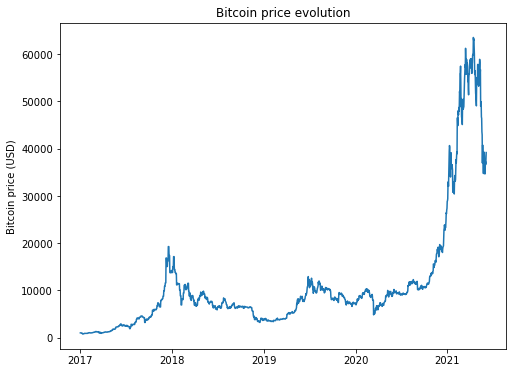

In [341]:
# Plotting the Bitcoin price between 2017 and 2021
date = final['market-price'].index
value = final['market-price']
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value);
plt.ylabel('Bitcoin price (USD)')
plt.title('Bitcoin price evolution')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/btc_price_years.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

*Both plots show us that the BTC is the most volatile asset, comparing to Gold and S&P500.*

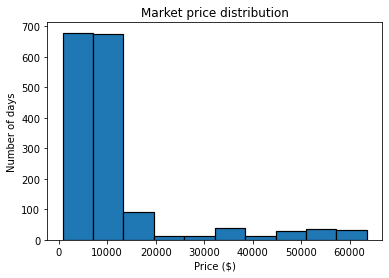

In [342]:
plt.hist(final['market-price'],edgecolor='black', linewidth=1.2)
plt.title('Market price distribution')
plt.ylabel('Number of days')
plt.xlabel('Price ($)')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hist_marketprice.jpg') # save this figure to use in the thesis
plt.show()

*As we can see, the BTC price is clearly skewed to the right. This means that we should apply log transformation to the variable.*

In [343]:
# Creating a new dataframe to model
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/final/final.xlsx',index_col=0)

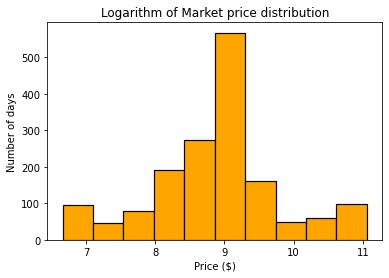

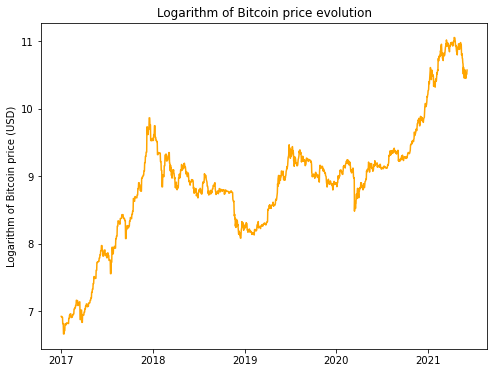

In [344]:
# Applying log transformation into price-variables, especially to make comparisions later on
model['market-price']=np.log(model['market-price'])
model['market-cap']=np.log(model['market-cap'])
model['High']=np.log(model['High'])
model['Low']=np.log(model['Low'])
model['Open']=np.log(model['Open'])
model['cost-per-transaction-percent']=np.log(model['cost-per-transaction-percent'])
model['fees-usd-per-transaction']=np.log(model['fees-usd-per-transaction'])
model['transaction-fees-usd']=np.log(model['transaction-fees-usd'])
model['Oil']=np.log(model['Oil'])
model['SP500']=np.log(model['SP500'])
model['Gold']=np.log(model['Gold'])
model['miners-revenue']=np.log(model['miners-revenue'])


# Rename the log variables
model = model.rename(columns={'market-price': 'lg_price'})
model = model.rename(columns={'market-cap': 'lg_market-cap'})
model = model.rename(columns={'High': 'lg_High'})
model = model.rename(columns={'cost-per-transaction-percent': 'lg_cost-per-transaction-percent'})
model = model.rename(columns={'Open': 'lg_Open'})
model = model.rename(columns={'Low': 'lg_Low'})
model = model.rename(columns={'fees-usd-per-transaction': 'lg_fees-usd-per-transaction'})
model = model.rename(columns={'transaction-fees-usd': 'lg_transaction-fees-usd'})
model = model.rename(columns={'Oil': 'lg_Oil'})
model = model.rename(columns={'SP500': 'lg_SP500'})
model = model.rename(columns={'Gold': 'lg_Gold'})
model = model.rename(columns={'miners-revenue': 'lg_miners-revenue'})

# Visualize the new transformation
plt.hist(model['lg_price'],edgecolor='black', linewidth=1.2, color='orange')
plt.title('Logarithm of Market price distribution')
plt.ylabel('Number of days')
plt.xlabel('Price ($)')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hist_logprice.jpg') # save this figure to use in the thesis
plt.show()

date = model['lg_price'].index
value = model['lg_price']
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,color='orange');
plt.ylabel('Logarithm of Bitcoin price (USD)')
plt.title('Logarithm of Bitcoin price evolution')
plt.show()

*Now we have a Normal Distribution as intended.*

*Next, we are going to investigate the same issue for some explanatory variables where we may need to apply the same solution.*

Text(0.5, 1.0, '12')

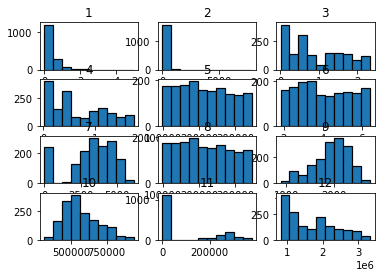

In [345]:
# Check the distributions and outliers of teh other variables
#Plot 1 - Trade Volume
plt.subplot(4,3,1)
plt.hist(model['trade-volume'],edgecolor='black', linewidth=1.2)
plt.title('1')

#Plot 2 - Average Confirmation Time
plt.subplot(4,3,2)
plt.hist(model['avg-confirmation-time'],edgecolor='black', linewidth=1.2)
plt.title('2')

#Plot 2 - difficulty
plt.subplot(4,3,3)
plt.hist(model['difficulty'],edgecolor='black', linewidth=1.2)
plt.title('3')

#Plot 4 - Hash rate
plt.subplot(4,3,4)
plt.hist(model['hash-rate'],edgecolor='black', linewidth=1.2)
plt.title('4')

#Plot 5 - block size
plt.subplot(4,3,5)
plt.hist(model['block-size'],edgecolor='black', linewidth=1.2)
plt.title('5')

#Plot 6 - total of transactions
plt.subplot(4,3,6)
plt.hist(model['n-transactions-total'],edgecolor='black', linewidth=1.2)
plt.title('6')

#Plot 7 - number of payments per block
plt.subplot(4,3,7)
plt.hist(model['n-payments-per-block'],edgecolor='black', linewidth=1.2)
plt.title('7')
          
#Plot 8 - block size
plt.subplot(4,3,8)
plt.hist(model['block-size'],edgecolor='black', linewidth=1.2)
plt.title('8')
          
#Plot 9 - Total of BTC circulating
plt.subplot(4,3,9)
plt.hist(model['Total-circulating-BTC'],edgecolor='black', linewidth=1.2)
plt.title('9')
          
#Plot 10 - number of unique addresses
plt.subplot(4,3,10)
plt.hist(model['n-unique-addresses'],edgecolor='black', linewidth=1.2)
plt.title('10')
          
#Plot 11 - number of transactions per block
plt.subplot(4,3,11)
plt.hist(model['n-transactions-per-block'],edgecolor='black', linewidth=1.2)
plt.title('11')
          
#Plot 12 - output volume
plt.subplot(4,3,12)
plt.hist(model['output-volume'],edgecolor='black', linewidth=1.2)
plt.title('12')

*The plots number 1,2,3,4,9,10,12 are skewed. Thefore,it seems reasonable to use log transformation for all these plots.In the other situations, the log transformation does not make the desired improvements. Consequently, it will not be applied for those cases.*

Text(0.5, 1.0, '10')

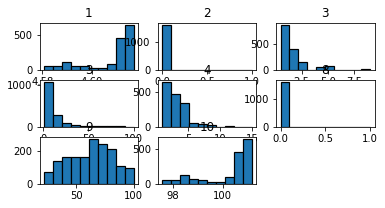

In [346]:
plt.subplot(4,3,1)
chines=np.log(model['Confidence'])
plt.hist(chines,edgecolor='black', linewidth=1.2)
plt.title('1')

plt.subplot(4,3,2)
plt.hist(model['News Regulation'],edgecolor='black', linewidth=1.2)
plt.title('2')

plt.subplot(4,3,3)
plt.hist(model['GT_legal'],edgecolor='black', linewidth=1.2)
plt.title('3')

plt.subplot(4,3,4)
plt.hist(model['GT_cryptocurrency'],edgecolor='black', linewidth=1.2)
plt.title('3')

plt.subplot(4,3,5)
plt.hist(model['GT_scam'],edgecolor='black', linewidth=1.2)
plt.title('4')

plt.subplot(4,3,6)
plt.hist(model['Theft'],edgecolor='black', linewidth=1.2)
plt.title('8')

plt.subplot(4,3,7)
plt.hist(model['Popularity'],edgecolor='black', linewidth=1.2)
plt.title('9')

plt.subplot(4,3,8)
plt.hist(model['Confidence'],edgecolor='black', linewidth=1.2)
plt.title('10')

In [347]:
## standardization
#confnovo=[]
#for i in range(len(model.Confidence)):
    #X=model.Confidence[i]
    #v=model.Confidence
    #confnovo.append((X-v.mean())/v.std())
    #continue
#plt.hist(confnovo)
#plt.show()


#for i in range(len(oilnovo)):
    #oilnovo.iloc[i,0]=(oilnovo.iloc[i,0]-oilnovo.iloc[:,0].mean())/oilnovo.iloc[:,0].std()
    #continue
#oilnovo= pd.DataFrame(oilnovo)
#print(oilnovo.mean(),oilnovo.std())
#plt.hist(oilnovo)
#plt.show()
#plt.hist(model.Oil)
#plt.show()
#plt.hist(np.log(model['Confidence']))

In [348]:
# Log transformation
model['trade-volume']=np.log(model['trade-volume'])
model['avg-confirmation-time']=np.log(model['avg-confirmation-time'])
model['difficulty']=np.log(model['difficulty'])
model['hash-rate']=np.log(model['hash-rate'])
model['Total-circulating-BTC']=np.log(model['Total-circulating-BTC'])
model['n-unique-addresses']=np.log(model['n-unique-addresses'])
model['output-volume']=np.log(model['output-volume'])

# Rename the variables
model = model.rename(columns={'trade-volume': 'lg_trade-volume'})
model = model.rename(columns={'avg-confirmation-time': 'lg_avg-confirmation-time'})
model = model.rename(columns={'difficulty': 'lg_difficulty'})
model = model.rename(columns={'hash-rate': 'lg_hash-rate'})
model = model.rename(columns={'Total-circulating-BTC': 'lg_circulatingBTC'})
model = model.rename(columns={'n-unique-adresses': 'lg_n-unique-adresses'})
model = model.rename(columns={'trade-volume': 'lg_trade-volume'})
model = model.rename(columns={'output-volume': 'lg_output-volume'})

In [349]:
# Export the dataset to Excelthat will be used to modelling
model.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx')

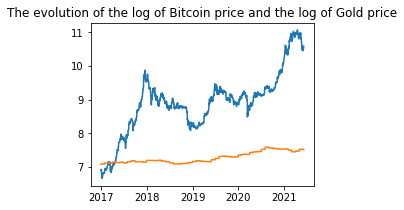

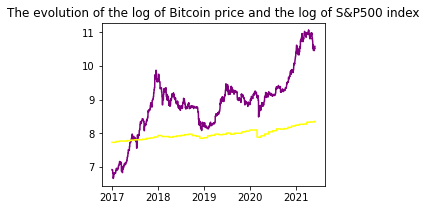

In [350]:
# Plotting the the log of Bitcoin price vs the log of Gold price between 2017 and 2021
date = model['lg_price'].index
value = model['lg_price']
value1 = model['lg_Gold']
value2 = model['lg_SP500']
fig, ax = plt.subplots(figsize=(4, 3))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,value1);
plt.title('The evolution of the log of Bitcoin price and the log of Gold price')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/BTCvsGold.jpg') # save this figure to use in the thesis

# Plotting the log of Bitcoin price vs the log of SP500 price between 2017 and 2021
fig, ax = plt.subplots(figsize=(4, 3))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,color='purple')
ax.plot(date, value2,color='yellow')
plt.title('The evolution of the log of Bitcoin price and the log of S&P500 index')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/BTCvsSP500.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

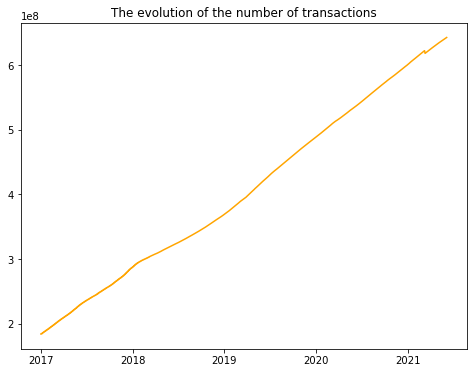

In [351]:
# PLot number of transactions of BTC over time
date = final['n-transactions-total'].index
value = final['n-transactions-total']
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
ax.plot(date, value,color='orange');
plt.title('The evolution of the number of transactions')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/n_transactions.jpg') # save this figure to use in the thesis
plt.show() # Plot the graph so we can see the results

*This plot shows that there is clearly a peak in 2020 on the number of BTC transactions and since then the variable is still decreasing.*

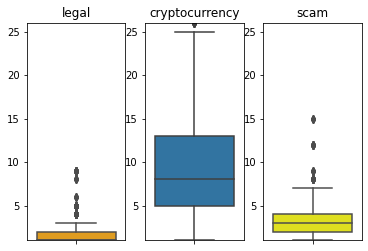

In [352]:
# Finding which keyword associated with Bitcoin that is more frequent in Google Trends
# Bitcoin+legal - POSITIVE SENTIMENT
plt.subplot(1,3,1)
sns.boxplot(y='GT_legal',data=model,color='orange')
plt.ylim(1, 26)
plt.ylabel('')
plt.title('legal')

# Bitcoin+cryptocurrency - NEUTRAL SENTIMENT
plt.subplot(1,3,2)
sns.boxplot(y='GT_cryptocurrency',data=model)
plt.ylim(1, 26)
plt.ylabel('')
plt.title('cryptocurrency')

# Bitcoin+scam - NEGATIVE SENTIMENT
plt.subplot(1,3,3)
sns.boxplot(y='GT_scam',data=model, color='yellow')
plt.ylim(1, 26)
plt.ylabel('')
plt.title('scam')

# Save this figure to use in the thesis
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/GT_boxplots.jpg') 

*It seems that, on average, the neutral sentiment regarding Bitcoin is the more predominat, comparing to the positive sentiment and the negative sentiment expressed through Google searches.*

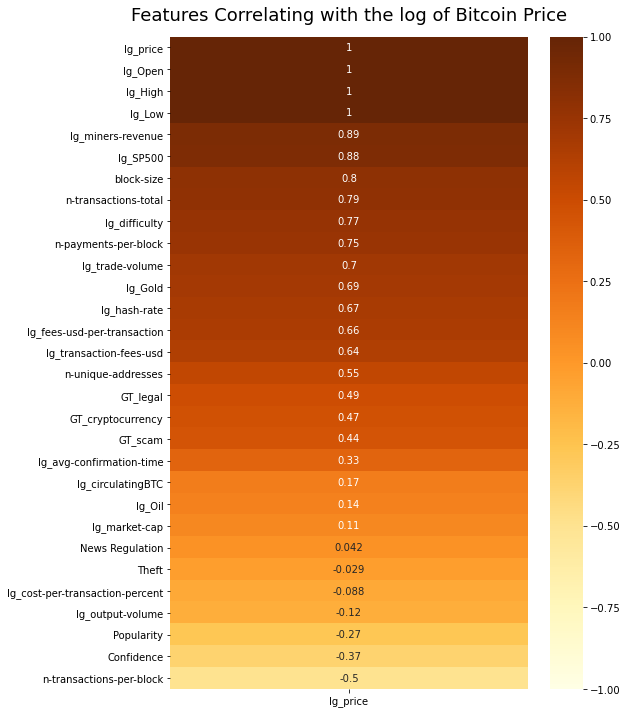

In [353]:
model.corr()[['lg_price']].sort_values(by='lg_price', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(model.corr()[['lg_price']].sort_values(by='lg_price', ascending=False), vmin=-1, vmax=1, annot=True, cmap="YlOrBr")
heatmap.set_title('Features Correlating with the log of Bitcoin Price', fontdict={'fontsize':18}, pad=16);
# save this figure to use in the thesis
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/wr_corr_heatmap.png') 

*Most important conclusions obtained from this correlations heatmap:*

*1. The log of SP500 presents the highest correlation in the log of BTC price and it is not a transactions-based variable.*

*2. Although "legal" is not the most frequent Google Trend keyword, comparing to the other two, it is the most correlated one with BTC price. Note that this keyword represents a positive sentiment regarding Bitcoin.*

*3. An interesting fact is that when consumers' confidence index increases, which reflects a positive sentiment about the general economic situation, unemployment and capability of savings, the log of BTC price decreases. In this case, will they demand substitute assets of BTC?*

*4. There are transaction-based variables that are not highly correlated with the log of BTC price, as it had been expected, namely the log of market capitalisation.*

### 2.2 - Time series

In [354]:
f = Forecaster(y=model['lg_price'],
                   current_dates=model.index)
f

Forecaster(
    DateStartActuals=2017-01-01T00:00:00.000000000
    DateEndActuals=2021-06-04T00:00:00.000000000
    Freq=None
    N_actuals=1615
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

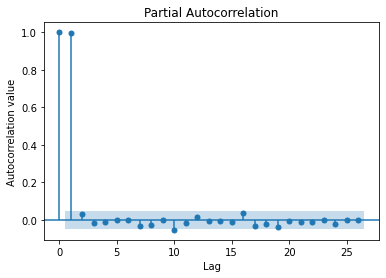

In [355]:
f.plot_pacf(lags=26)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation value')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/partial_autocorr.jpeg')
plt.show()

*It was decomposed this time series by viewing the PACF (Partial Auto Correlation Function) plot, which measures how much the y variable (lg_price) is correlated to past values of itself and how far back a statistically significant correlation exists. The PACF plot is different from the ACF plot in that PACF controls for correlation between past terms. It is good to view both, but only PACF will be displayed here.*

*This plot indicates a statistically significant correlation may exist up to two years in the data. That will be good information to use when modeling. Let’s further decompose the series into its trend, seasonal, and residual parts:*

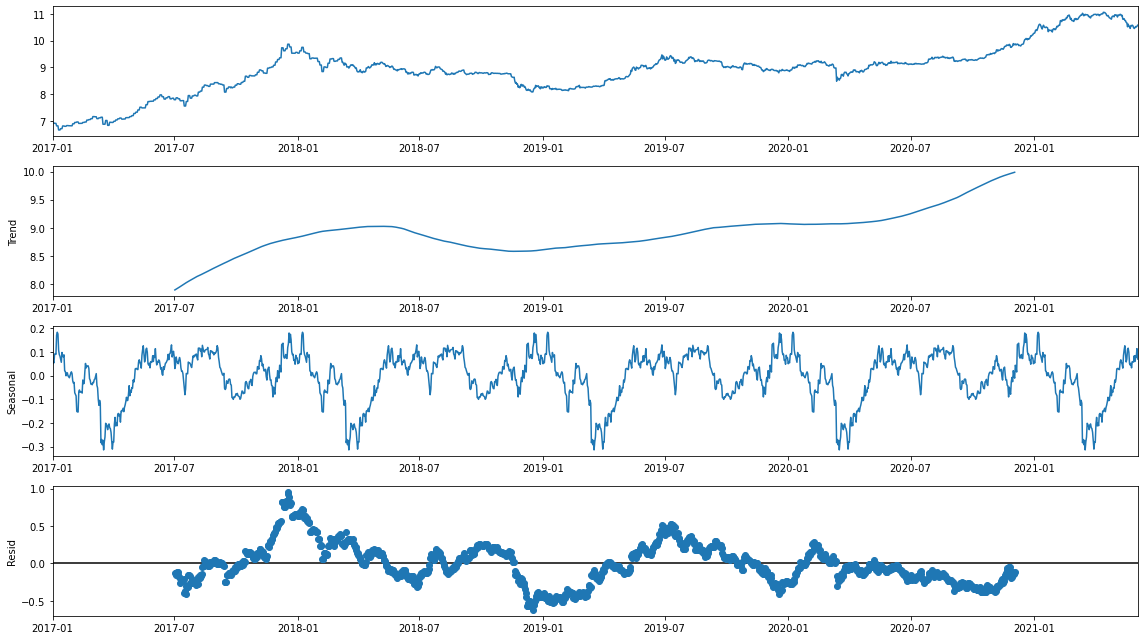

In [356]:
# Plotting time series decomposition: trend, seasonal, and residuals
fig=f.seasonal_decompose(period=365).plot()
fig.set_size_inches((16, 9))
fig.tight_layout() # Tight layout to realign things
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/series_decomposition.jpeg') # Save the picture
plt.show()

*Firstly, the second plot shows a a growing trend, but it is not linear.*

*Secondly, the next graph indicates the existence of seasonality in this data.*

*FInally, the residuals does not present a pattern.*

In [357]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat,pval)

-1.345697051034299 0.6080153946478775


*In this case, the trend is pretty clearly non-stationary as it is increasing upward year-after-year. In addition, the results of the Augmented Dickey-Fuller (ACF) test give statistical justification to what our eyes see. Since the p-value is not less than 0.05, we must assume the series is non-stationary.*

## 3. MODELLING

In [442]:
# Reading the model dataset
model = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

#Check the first observations
model.head(2)

,lg_price,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_avg-confirmation-time,lg_difficulty,lg_High,lg_Low,lg_hash-rate,block-size,...,lg_output-volume,Confidence,lg_Gold,News Regulation,GT_legal,GT_cryptocurrency,GT_scam,lg_SP500,lg_Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,23.527405,15.376856,11.651582,2.566197,26.484337,6.921086,6.862863,14.767149,97293.875547,...,14.342027,100.5115,7.083472,0,1.0,2,1,7.729786,3.961004,1
2017-01-02,6.921086,23.527405,15.376856,11.651582,4.578962,26.484337,6.938963,6.897907,14.767149,97293.875547,...,14.342027,100.5115,7.083472,0,1.0,2,1,7.729786,3.961004,0


### 3.1 - Generalized Least Squares (GLS)

* Data pre-processing

*To obtain BLUE estimators, it is necessary to respect the Gauss-Markov assumptions. Therefore, a data pre-processing will be made especifically to GLS.*

In [443]:
# Remove the variables with perfect collinearity
model= model.drop(['lg_Open','lg_High','lg_Low'],axis=1)

# Creating a dummy variable for GT means that it is necessary to drop one of the categories
model= model.drop(['GT_scam'],axis=1)

# Deleting the ratios that have variables included in the model in order to avoid multicollinearity
model= model.drop(['n-transactions-per-block','lg_cost-per-transaction-percent','lg_fees-usd-per-transaction','n-payments-per-block','lg_avg-confirmation-time','lg_circulatingBTC'],axis=1) 
model.head(2)

,lg_price,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_difficulty,lg_hash-rate,block-size,lg_miners-revenue,n-transactions-total,Popularity,n-unique-addresses,lg_output-volume,Confidence,lg_Gold,News Regulation,GT_legal,GT_cryptocurrency,lg_SP500,lg_Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,23.527405,15.376856,11.651582,26.484337,14.767149,97293.875547,14.575693,183961799.0,43,13.057525,14.342027,100.5115,7.083472,0,1.0,2,7.729786,3.961004,1
2017-01-02,6.921086,23.527405,15.376856,11.651582,26.484337,14.767149,97293.875547,14.575693,183961799.0,74,13.057525,14.342027,100.5115,7.083472,0,1.0,2,7.729786,3.961004,0


* Model formulation

In [444]:
# Check the dimentions of the model dataset
print(model.shape)

(1615, 20)


In [445]:
import statsmodels.api as sm
# Define the variables
model_exog=model.iloc[:,1:31]

# Put the target (lg_price) in another DataFrame
model_endog = model["lg_price"]
model_endog.sort_index(ascending=True)

# Add a constant to the explanatory variables
model_exog = sm.add_constant(model_exog) # let's add an intercept (beta_0) to our model
model_exog.sort_index(ascending=True)

,const,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_difficulty,lg_hash-rate,block-size,lg_miners-revenue,n-transactions-total,Popularity,n-unique-addresses,lg_output-volume,Confidence,lg_Gold,News Regulation,GT_legal,GT_cryptocurrency,lg_SP500,lg_Oil,Theft
Timestamp,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,23.527405,15.376856,11.651582,26.484337,14.767149,97293.875547,14.575693,1.839618e+08,43,13.057525,14.342027,100.5115,7.083472,0,1.0,2,7.729786,3.961004,1
2017-01-02,1.0,23.527405,15.376856,11.651582,26.484337,14.767149,97293.875547,14.575693,1.839618e+08,74,13.057525,14.342027,100.5115,7.083472,0,1.0,2,7.729786,3.961004,0
2017-01-03,1.0,23.527405,15.376856,11.651582,26.484337,14.767149,97293.875547,14.575693,1.839618e+08,69,13.057525,14.342027,100.5115,7.083472,0,1.0,2,7.729786,3.961004,0
2017-01-04,1.0,23.590040,15.583291,11.651582,26.484337,14.748687,97743.656720,14.575693,1.839618e+08,79,13.098717,14.402047,100.5115,7.083472,0,1.0,2,7.729786,3.961004,0
2017-01-05,1.0,23.590040,15.583291,11.711432,26.484337,14.579937,97743.656720,14.513546,1.848845e+08,100,13.098717,14.402047,100.5115,7.083472,0,1.0,2,7.729786,3.961004,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,1.0,20.478735,20.569115,15.233616,30.773573,18.901268,345130.862332,20.280450,6.422254e+08,33,13.447443,14.517931,100.2454,7.523081,0,4.0,26,8.335570,4.244487,0
2021-06-01,1.0,20.496639,20.555220,15.197400,30.770753,18.898910,345323.370462,20.280842,6.424775e+08,32,13.443656,14.509932,100.3988,7.514565,0,4.0,26,8.351962,4.244487,0
2021-06-02,1.0,20.788734,20.560902,15.171042,30.771387,18.890411,345516.426076,20.281233,6.427285e+08,30,13.444998,14.509911,100.3988,7.514565,0,4.0,26,8.351962,4.244487,0


In [446]:
X_train, X_test, y_train, y_test = train_test_split(model_exog, model_endog, test_size=0.2,shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1292, 20) (323, 20) (1292,) (323,)


In [447]:
glsar_model = sm.GLSAR(model_endog, model_exog, 2)
glsar_results = glsar_model.iterative_fit(2,(X_train.iloc[:,1:],y_train))
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:               lg_price   R-squared:                       0.943
Model:                          GLSAR   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1386.
Date:                Sun, 20 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:36:35   Log-Likelihood:                 2246.1
No. Observations:                1613   AIC:                            -4452.
Df Residuals:                    1593   BIC:                            -4345.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

* Predicting

In [448]:
# Predicting the first 5 values of lg_price
predictions=glsar_results.predict(X_test)
predictions

Timestamp
2020-07-16     9.116645
2020-07-17     9.084924
2020-07-18     9.091438
2020-07-19     9.064491
2020-07-20     9.127576
                ...    
2021-05-31    10.821517
2021-06-01    10.835761
2021-06-02    10.887668
2021-06-03    10.940885
2021-06-04    10.961003
Length: 323, dtype: float64

* Evaluation

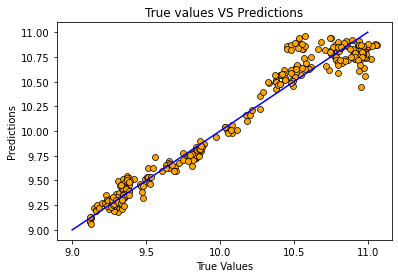

In [449]:
## The line / model
#?plt.plot
#plt.plot(y_test, predictions,linewidth=0.01,color='black')
plt.plot(range(9,12),range(9,12),color='blue')
plt.scatter(y_test, predictions,edgecolors='black',linewidths=0.7,color='orange')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True values VS Predictions')
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/linear_reg_predictionsVStrue.jpeg') # Save the picture
plt.show()

*The limitation of train/test split is if, by chance, the split made was not random.* 

*This will result in overfitting, even though it was tried to avoid it. Therefore, it is introduced cross validation.*

In [450]:
#from sklearn.model_selection import cross_val_score
#CV_MSE = np.mean(-cross_val_score(glsar_model, X_train, y_train, cv = 10 ,scoring = "neg_mean_squared_error" ))
#CV_RMSE = np.sqrt(CV_MSE)
#print('Cross-validated scores:', scores)

In [451]:
# 1. MSE - Mean Squared Error
MSE = np.square(np.subtract(y_test,predictions)).mean() 
print("Mean Square Error: ", MSE)

# 2. RMSE - Root Mean Square Error
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: ", RMSE)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
sMAPE=smape(y_test,predictions)
print('sMAPE: ',sMAPE)

# 4. R^2 score
r2_score = metrics.r2_score(y_test, predictions)
print('R^2 score: ',r2_score)

Mean Square Error:  0.01768785685204124
Root Mean Square Error:  0.13299570238184857
sMAPE:  0.009552112799844312
R^2 score:  0.9606452115259332


* Analysis

In [452]:
coefficients = glsar_results.params
coefficients=pd.DataFrame(coefficients)
coefficients.rename(columns={ coefficients.columns[0]: "coefficient" }, inplace = True)
coefficients
external=coefficients.loc[["Confidence","lg_Gold",'News Regulation', 'GT_legal','GT_cryptocurrency','Theft','lg_Oil','lg_SP500','Popularity']]

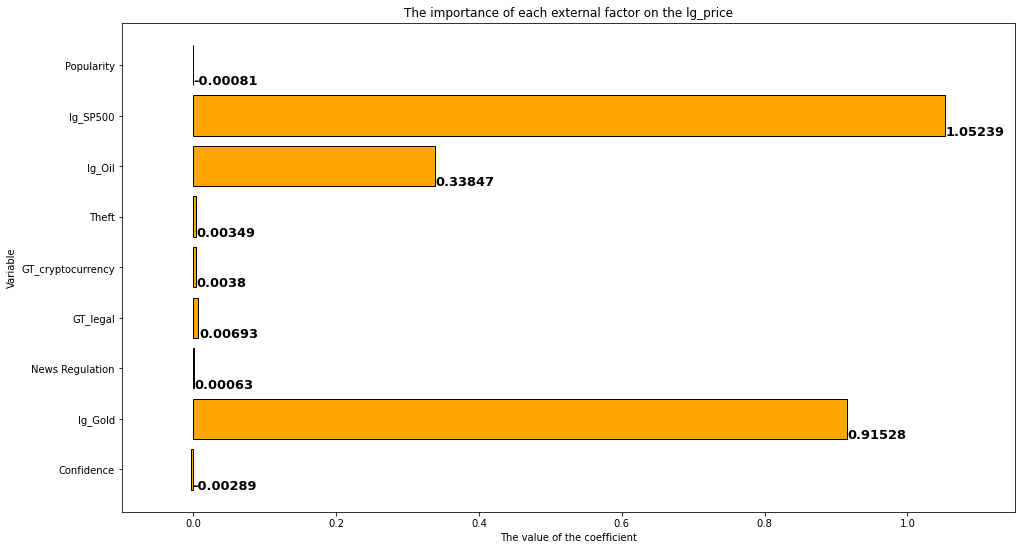

In [453]:
## Creatinga horizontal bar plot to visualize the external coefficients
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(external.index,external['coefficient'],color='orange',edgecolor='black',data=external)

# Adding annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.001, i.get_y()+0.011,
             str(round((i.get_width()), 5)),
             fontsize = 13, fontweight ='bold',
             color ='black')
    
# Adding a title
plt.title('The importance of each external factor on the lg_price')

# Adding labels to the axis
plt.ylabel('Variable')
plt.xlabel('The value of the coefficient')

# Setting the x limit
plt.xlim(-0.1,1.15)

plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hbar_plot_externalcoeff.jpeg') # Save the picture

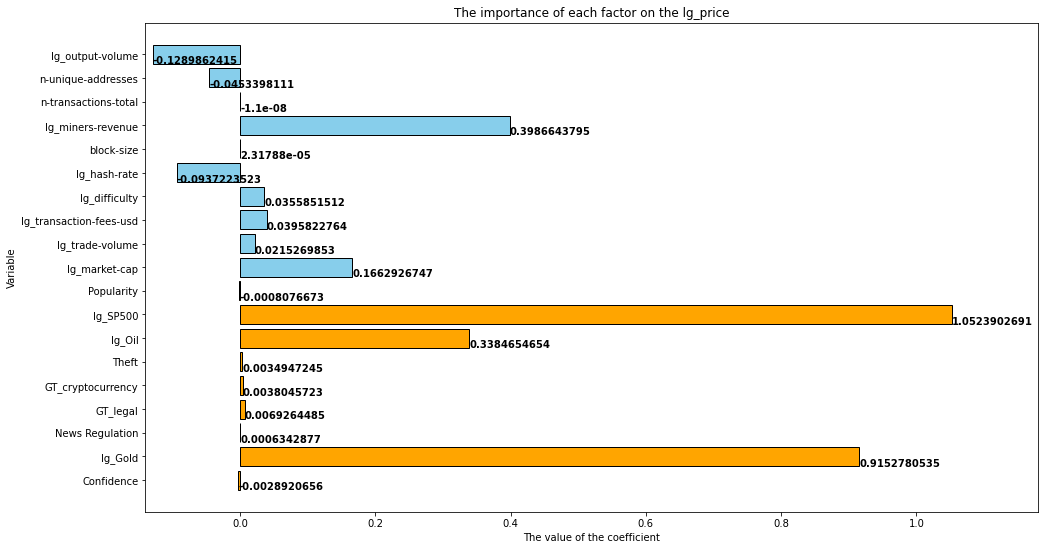

In [454]:
## Creatinga horizontal bar plot to visualize the external coefficients
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

transaction= coefficients.drop(["const","Confidence","lg_Gold","News Regulation", "GT_legal","GT_cryptocurrency","Theft","lg_Oil","lg_SP500","Popularity"]) # Dropping the variables that are extremely correlated with lg_price

# Horizontal Bar Plot
ax.barh(external.index,external['coefficient'],color='orange',edgecolor='black',data=external)
ax.barh(transaction.index,transaction['coefficient'],edgecolor='black',color='skyblue',data=transaction)
    
# Adding a title
plt.title('The importance of each factor on the lg_price')

# Adding labels to the axis
plt.ylabel('Variable')
plt.xlabel('The value of the coefficient')

# Setting the x limit
plt.xlim(-0.14,1.18)

# Adding annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.00011, i.get_y()+0.000111,
             str(round((i.get_width()), 10)),
             fontsize = 10, fontweight ='bold',
             color ='black')

#plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/hbar_plot_all.jpeg') # Save the picture

### 3.2 - Long Short-Term Memory (LSTM)

In [487]:
# Reading the model dataset
model1 = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

* Data preparation:

In [488]:
# Splitting 80% for training and 20% for testing
train = model1[:-323]
len(train)
test = model1[-323:]
len(test)

print(len(train), 'train sequences')
print(len(test), 'test sequences')

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train['lg_price'].values.reshape(-1,1))

prediction_days = 323

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])


x_train1, y_train1 = np.array(x_train), np.array(y_train)
x_train1 = np.reshape(x_train1, (x_train1.shape[0], x_train1.shape[1], 1))

1292 train sequences
323 test sequences


In [489]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.layers import InputLayer

* Build the model

In [508]:
lstm = Sequential()

lstm.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (x_train1.shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units =128, activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units =128, activation='relu', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1)) # Prediction of the next value

lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

history = lstm.fit(x_train1, y_train1, epochs = 25, batch_size=32, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 323, 128)          66560     
                                                                 
 dropout_6 (Dropout)         (None, 323, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 323, 128)          131584    
                                                                 
 dropout_7 (Dropout)         (None, 323, 128)          0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
loss = lstm.history['loss']
val_loss = lstm.history['val_loss']

epochs= range(1,26)

TL=plt.plot(epochs, loss, 'bo', label='Training loss')
VL=plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'])
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/trainVSvalid.jpeg')
plt.show()

In [510]:
lstm.save('lstm_model')

In [511]:
from keras.models import load_model
lstm = load_model('lstm_model')

*The plot shows that the training operation becomes stable after the second epoch time.*

* Prediction

In [499]:
actual_price = test['lg_price'].values
total_price = pd.concat((train['lg_price'], test['lg_price']),axis=0) # tirar x_train

model_inputs = total_price[len(total_price)-len(test)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


# Make Predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test1 = np.array(x_test)
x_test2 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1))

# Predicting the values for lg_price
pred = lstm.predict(x_test2)
pred = scaler.inverse_transform(pred)
print(pred[:5]) # Printing lg_price for the next 5 day to check if the values make sense

[[9.046828]
 [9.047158]
 [9.047295]
 [9.047233]
 [9.047015]]


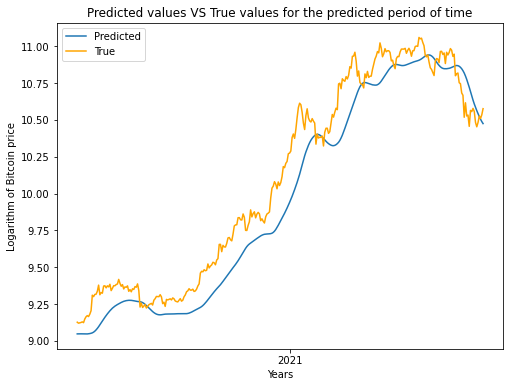

In [500]:
# Plotting the Predicted Bitcin price VS True Bitcoin price for the predicted period of time
original_test=model1.iloc[-323:,0]
date = original_test.index
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
plt.plot(date, pred)
plt.plot(date, original_test,color='orange')
plt.title('Predicted values VS True values for the predicted period of time')
plt.xlabel('Years')
plt.ylabel('Logarithm of Bitcoin price')
plt.legend(['Predicted', 'True'])
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/originalVSpred.jpeg')
plt.show()

*Therefore, in this case, LSTM leads to slightly undervalued predictions most of the time.*

In [515]:
from sklearn.metrics import mean_squared_error

# 1. MSE - Mean Squared Error
MSE2 = mean_squared_error(actual_price,pred)
print("Mean Square Error: ", MSE2)

# 2. RMSE - Root Mean Square Error
RMSE2 = math.sqrt(MSE2)
print("Root Mean Square Error: ", RMSE2)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
sMAPE2=smape(actual_price,pred)
print('sMAPE: ',sMAPE2)

# 4. R^2 score
r2_score2 = metrics.r2_score(actual_price,pred)
print('R^2 score: ',r2_score2)

Mean Square Error:  0.033557784537639516
Root Mean Square Error:  0.1831878394917073
sMAPE:  25.21501094510724


AttributeError: 'DataFrame' object has no attribute 'r2_score'

In [517]:
# Defining a dictionary
d = {'Model': ['GLS','LSTM'],'MSE': [MSE,MSE2],'RMSE':[RMSE,RMSE2],'sMAPE':[sMAPE,sMAPE2],'R^2 score': [r2_score,r2_score2]}

# Creating a dataframe to compare the evaluation metrics results of the 2 models
metrics=pd.DataFrame(d, index=[0,1])
metrics


,Model,MSE,RMSE,sMAPE,R^2 score
0,GLS,0.017688,0.132996,0.009552,0.960645
1,LSTM,0.033558,0.183188,25.215011,0.940389


### 3.3 - SHAP applied on LSTM

In [ ]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

**(A) Variable Importance Plot — Global Interpretability**

In [ ]:
# init the JS visualization code
shap.initjs()

In [ ]:
tf.compat.v1.disable_v2_behavior()
# compute SHAP values
explainer = shap.DeepExplainer(lstm, x_train1)
shap_values = explainer.shap_values(x_train1)

In [ ]:
tf.compat.v1.keras.backend.get_session
tf.compat.v1.disable_v2_behavior()
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# select backgroud for shap
background = x_train1
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(lstm, background)
# compute shap values
shap_values = explainer.shap_values(x_train1)

In [ ]:

# pool data needed for model to calculate shaps
explainer = shap.Explainer(lstm)
    # pool = test_data
shap_values = explainer(x_test1,max_evals=647)
    # names of columns
#shap_values.data = x_test.columns
type(x_train1)

In [ ]:
print(x_test1[0].shape)
print(x_test1.shape[0])

In [ ]:
explainer=shap.Explainer(lstm)

In [ ]:
#x_test = list(x_test)

explainer = shap.explainers.Permutation(lstm, x_train,max_evals = 647)
shap_values = explainer(x_test)

In [ ]:
explainer = shap.Explainer(lstm)
shap_values = explainer(x_test)